# Classification model evaluation

In [2]:
import os
main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(main_dir)

import pyvdirs.dirs as dirs
import sys
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

In [3]:
import torch
import torchvision as torchv
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pyvtorch.aux as vtaux
import timm
import PIL
from pyvtools.text import find_numbers, filter_by_string_must
from sklearn import metrics
from jeevan.wavemix.classification import WaveMix

import karras.dnnlib as dnnlib
from karras.training.encoders import PRETRAINED_HOME
import Images.calculate_metrics as calc
import Images.generate_images as gen
import Images.get_validation_metrics as valm
import ours.utils as utils

%load_ext autoreload
%autoreload 2

/mnt/hdd/vale/.conda/SCIDev2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basics

### Load dataset

In [3]:
dataset_name = "tiny"

In [4]:
dataset_kwargs = calc.get_dataset_kwargs(dataset_name, image_path=None)
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs, random_seed=0)

In [5]:
dataset_obj.get_details(499)

{'raw_idx': 499,
 'xflip': False,
 'raw_label': 0,
 'name_label': 'n01443537',
 'words_label': 'Goldfish, carassius auratus'}

In [12]:
np.save( os.path.join("/mnt/hdd/vale/data/SCID/tiny", "0.npy"), dataset_obj[0][1].detach().cpu().swapaxes(0,1).swapaxes(1,2).numpy().astype(np.uint8) )

In [29]:
get_raw_idx = lambda idx : int(int(dataset_obj._raw_idx[idx]))
get_raw_label = lambda idx : int(dataset_obj._load_raw_label(get_raw_idx(idx)))
get_name_label = lambda idx : dataset_obj.data.features[dataset_obj.key_label].names[get_raw_label(idx)]
get_words_label = lambda idx : dataset_obj.class_names[get_name_label(idx)]
get_name_from_label = lambda lab : dataset_obj.data.features[dataset_obj.key_label].names[lab]
get_words_from_label = lambda lab : dataset_obj.class_names[get_name_from_label(lab)]

In [30]:
get_words_from_label(193)

'Acorn'

## WaveMix-192/16 (level 3)

### Load model

In [22]:
model = valm.load_wavemix_model(verbose=True)

> Have the model parameters changed? True
> Which fraction of them changed? 100.00%


In [23]:
model

WaveMix(
  (layers): ModuleList(
    (0-15): 16 x Level3Waveblock(
      (feedforward1): Sequential(
        (0): Conv2d(288, 384, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.5, inplace=False)
        (3): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1))
        (4): ConvTranspose2d(192, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (feedforward2): Sequential(
        (0): Conv2d(288, 384, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.5, inplace=False)
        (3): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1))
        (4): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (feedforward3): Sequential(
        (0): Conv2d(192, 38

### Get classification metrics for the dataset

In [26]:
n_samples = 10
batch_size = 1
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, 
                                          do_upsample=True, upsample_dim=128,
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "wavemix"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:01<00:00,  7.03it/s]

Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [25]:
confusion_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=uint32)

In [27]:
n_samples = 4000
batch_size = 100
save_period = 5
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False,
                                          save_dir=os.path.join(dirs.DATA_HOME, "class_metrics", "tiny", "wavemix"))
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 40/40 [02:22<00:00,  3.55s/it]

Top-1 Accuracy 0.00025
Top-5 Accuracy 0.005


In [28]:
confusion_matrix[0].argmax()

np.int64(22)

In [29]:
confusion_matrix[1].argmax()

np.int64(29)

In [30]:
confusion_matrix[2].argmax()

np.int64(29)

In [31]:
confusion_matrix[4].argmax()

np.int64(29)

In [32]:
confusion_matrix[:4]

array([[  0,   5,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
         12,   0,   1,   0,   0,   3,   0,   2,   3, 101,   0,   1,  30,
          0,   0,   0,  10,  29,   5,   0,   2,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
          0,   0,   0,   0,   2,   0,   0,   0,   0,   1,  89,   5,   0,
          3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   1,   0,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   2,   4,   0,
          1,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  18,   0,   1,   5,   1,   0,   1,
          1,   0,   0,   0,   0,   6,  13,   1,  13,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   1,   1,   0,  60,   0,   0,   4,   0

## ResNet-101

### Load model

In [8]:
model = valm.load_resnet_101_model(verbose=True)
model.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1,1))
model.eval()

Loading ResNet-101 for TinyImageNet
> Have the model parameters changed? True
> Which fraction of them changed? 100.00%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[ 1.6219e-02, -8.1124e-03, -2.0647e-02,  ..., -1.6463e-02,
           -1.4927e-04,  1.1889e-02],
          [-1.5075e-02, -9.0934e-03, -2.7991e-02,  ..., -9.1025e-02,
           -7.7257e-02, -3.9201e-02],
          [-3.6561e-03,  1.9346e-02,  4.3625e-02,  ...,  3.2203e-02,
            1.5482e-02,  3.1234e-02],
          ...,
          [-4.8363e-02, -1.3125e-01, -2.9607e-01,  ..., -3.6000e-01,
           -1.2723e-01,  3.4665e-02],
          [-1.1324e-03,  1.6052e-02,  7.0292e-03,  ..., -1.5757e-01,
           -1.8505e-01, -1.1095e-01],
          [-3.9803e-02, -1.2397e-02,  5.3014e-02,  ...,  1.6523e-01,
            9.6289e-02, -2.5995e-02]],

         [[ 1.1675e-02, -3.2693e-03, -9.8972e-03,  ..., -9.3783e-03,
            2.2246e-02,  2.7261e-02],
          [-1.1643e-02,  3.3755e-03, -1.5723e-02,  ..., -8.1126e-02,
           -5.6523e-02, -1.5057e-02],
          [-4.6527e-03,  2.8838e-02,  7.2211e-02,  ...,  9.0631e-02,
            5.6185e-02,  4.1675e-02]

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Get classification metrics for the dataset

In [9]:
n_samples = 10
batch_size = 1
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:00<00:00, 22.54it/s]


Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [11]:
confusion_matrix[0].argmax()

np.int64(193)

In [10]:
confusion_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
       0, 0], dtype=uint32)

In [11]:
n_samples = 10
batch_size = 1
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 200]) tensor([193]) tensor([[163, 140, 145, 159, 193]])
Inconsistency found: n_seen is 1, but n_samples is 10
Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [12]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:00<00:00, 11.38it/s]

Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


In [12]:
n_samples = 4000
batch_size = 100
save_period = 5
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=False)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 40/40 [00:51<00:00,  1.28s/it]

Top-1 Accuracy 0.0
Top-5 Accuracy 0.0


### Load results

In [50]:
confusion_matrix, top_5_correct = valm.load_last_classification_metrics("ResNet")

In [51]:
100e3/200

500.0

In [52]:
confusion_matrix[0].argmax()

np.int64(193)

In [43]:
confusion_matrix[1].argmax()

np.int64(193)

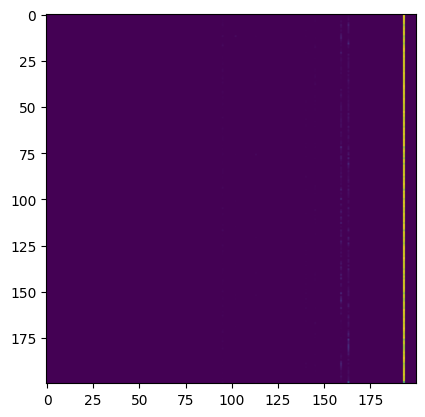

In [53]:
plt.imshow(confusion_matrix/confusion_matrix.max())

## Swin-L

### Load model

In [6]:
model = valm.load_swin_l_model(verbose=True)

Loading Swin-L for TinyImageNet


/home/valeria/anaconda3/envs/SCIDev/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


> Have the model parameters changed? True
> Which fraction of them changed? 100.00%


### Get classification metrics for the dataset

In [7]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics(model, "tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True, do_upsample=True)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

100%|██████████| 10/10 [00:38<00:00,  3.86s/it]

Top-1 Accuracy 0.4
Top-5 Accuracy 0.77


### Load results

In [37]:
confusion_matrix, top_5_correct = valm.load_last_classification_metrics("Swin")

In [17]:
confusion_matrix[0]

array([40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 32,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  7,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint32)

In [38]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

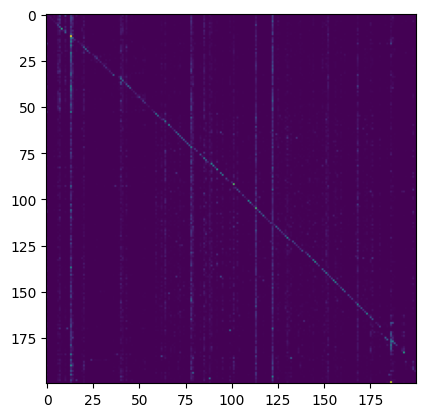

In [8]:
plt.imshow(confusion_matrix/confusion_matrix.max())